In [3]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [4]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.observations.ar_gaussian_observation import ARGaussianObservation
from ssm_ptc.transformations.linear import LinearTransformation
from ssm_ptc.transformations.constrained_linear import ConstrainedLinearTransformation
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from hips.plotting.colormaps import gradient_cmap, white_to_color_cmap
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from tqdm import tqdm_notebook as tqdm
import time

# Generate synthetic data from constrained ARHMM

In [10]:
torch.manual_seed(0)

K = 3
D = 2
T = 100

As = [random_rotation(D) for _ in range(K)]
bounds = np.array([[0, 20], [0,40]])

thetas = np.linspace(0, 2 * np.pi, K, endpoint=False)
mus_init = 3 * np.column_stack((np.cos(thetas), np.sin(thetas)))

In [11]:
true_tran = ConstrainedLinearTransformation(K=K, D=D, lags=1, As=As, bounds=bounds)
true_observation = ARGaussianObservation(K=K, D=D, M=0, transformation=true_tran, mus_init=mus_init)
true_model = HMM(K=K, D=D, M=0, observation=true_observation)

z, y = true_model.sample(T, return_np=False)
true_ll = true_model.log_likelihood(y)

In [14]:
torch.abs(y).max()

tensor(55.5552, dtype=torch.float64)

In [21]:
# Plot the observation distributions
lim = .85 * abs(y.numpy()).max()
XX, YY = np.meshgrid(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100))
data = np.column_stack((XX.ravel(), YY.ravel()))
lls = true_model.observation.log_prob(torch.tensor(data, dtype=torch.float64))

In [39]:
data.shape

(10000, 2)

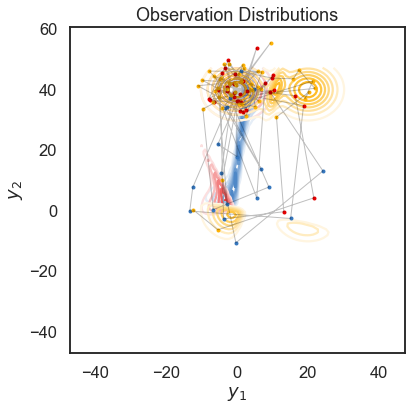

In [44]:
plt.figure(figsize=(6, 6))
for k in range(K):
    plt.contour(XX, YY, np.exp(lls[:,k].detach().numpy()).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    plt.plot(y[z==k, 0].numpy(), y[z==k, 1].numpy(), 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(y[:,0].numpy(), y[:,1].numpy(), '-k', lw=1, alpha=.25)
plt.xlabel("$y_1$")
plt.ylabel("$y_2$")
plt.title("Observation Distributions");

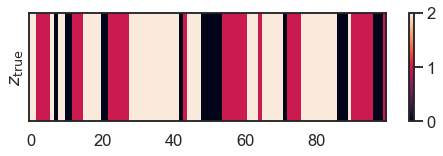

In [29]:
slc = slice(0, T)

plt.figure(figsize=(8, 2))
plt.imshow(z[None, slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.colorbar()

# Fit a constrained ARHMM to the data

In [112]:
tran = ConstrainedLinearTransformation(K=K, D=D, lags=1, bounds=bounds)
observation = ARGaussianObservation(K=K, D=D, M=0, transformation=tran)
model = HMM(K=K, D=D, M=0, observation=observation)

model.observation.mus_init = true_model.observation.mus_init

In [113]:
num_iters = 1000

pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.005)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(y)    
    loss.backward()
    optimizer.step()
    
    loss = loss.detach().numpy()
    losses.append(loss)
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)

In [127]:
num_iters = 1000

pbar = tqdm(total=num_iters, file=sys.stdout)

optimizer = torch.optim.Adam(model.params, lr=0.001)

losses = []
for i in np.arange(num_iters):

    optimizer.zero_grad()

    loss = model.loss(y)    
    loss.backward()
    optimizer.step()
    
    loss = loss.detach().numpy()
    losses.append(loss)
    
    if i % 10 == 0:
        pbar.set_description('iter {} loss {:.2f}'.format(i, loss))
        pbar.update(10)

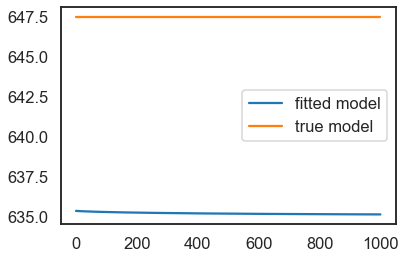

In [128]:
true_loss = true_model.loss(y)
plt.plot(losses, label='fitted model')
plt.plot(np.arange(num_iters), [true_loss]*num_iters, label='true model')
plt.legend()
plt.show()

In [129]:
infer_z = model.most_likely_states(y)

perm = find_permutation(z.numpy(), infer_z, K1=K, K2=K)

model.permute(perm)
infer_z = model.most_likely_states(y)

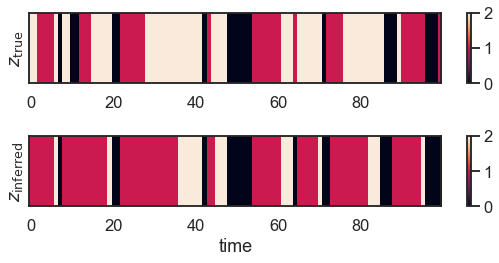

In [130]:
# Plot the true and inferred discrete states
slc = slice(0, T)

plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.imshow(z[None, slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{true}}$")
plt.yticks([])
plt.colorbar()

plt.subplot(212)
plt.imshow(infer_z[None,slc], aspect="auto")
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")
plt.colorbar()

plt.tight_layout()

# check prediction

In [131]:
x_predict_cond_z = k_step_prediction(model, z, y)

In [132]:
x_predict_cond_most_likely_z = k_step_prediction(model, infer_z, y)

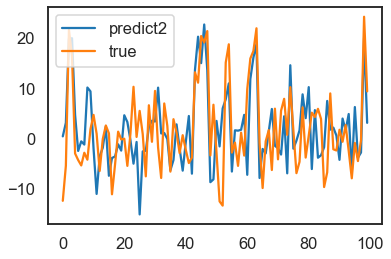

In [139]:
#plt.plot(x_predict_cond_z[:,0], label='predict')
plt.plot(x_predict_cond_most_likely_z[:,0], label='predict2')
plt.plot(y[:,0].numpy(), label='true')
plt.legend()

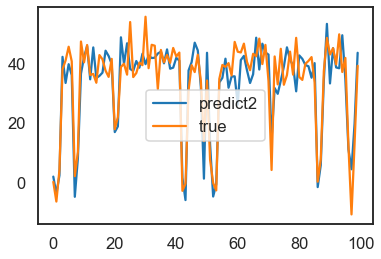

In [140]:
#plt.plot(x_predict_cond_z[:,0], label='predict')
plt.plot(x_predict_cond_most_likely_z[:,1], label='predict2')
plt.plot(y[:,1].numpy(), label='true')
plt.legend()

In [170]:
sample_z, sample_x  = model.sample(T)

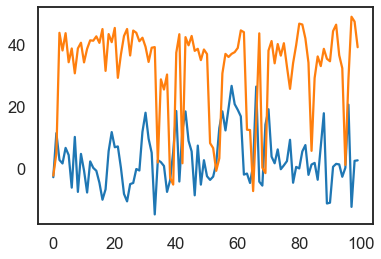

In [171]:
plt.plot(sample_x)

In [172]:
bounds

array([[ 0, 20],
       [ 0, 40]])

In [174]:
np.max(sample_x, axis=0)

array([26.81713122, 49.17657005])

In [176]:
np.min(sample_x, axis=0)

array([-14.76445208,  -7.21272775])

In [178]:
model.observation.log_sigmas.exp()

tensor([[6.0625, 4.7582],
        [5.0441, 5.3640],
        [4.0922, 3.6924]], dtype=torch.float64, grad_fn=<ExpBackward>)